# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [29]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import pandas as pd 
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
#checking for nulls userId
df.filter(df['userId']=='').count()

8346

In [8]:
#checking for nulls sessionIds
df.filter(df['userId']=='').count()

8346

In [9]:
#remove nulls
df = df.filter(df.userId!="")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
#create view
df.createOrReplaceTempView("Sparkify")

In [19]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [20]:
#5 users who did cancelation event
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(5)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
+------+
only showing top 5 rows



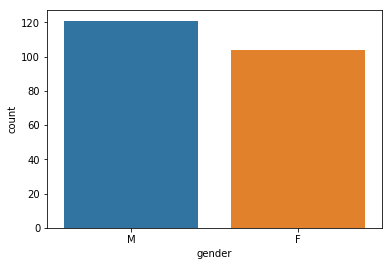

In [22]:
genders = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS count
        FROM Sparkify
        GROUP BY gender
        ORDER BY count DESC
''')
sns.barplot(x='gender',y='count',data=genders.toPandas());

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

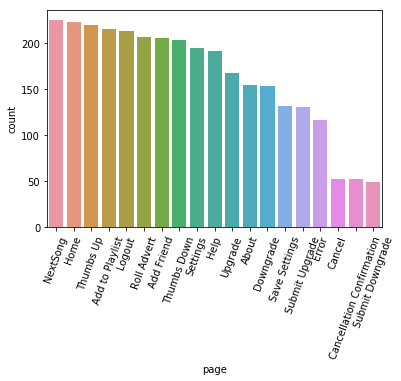

In [30]:
pages = spark.sql('''
        SELECT page,COUNT(DISTINCT userId) AS count
        FROM Sparkify
        GROUP BY page
        ORDER BY count DESC
''')
sns.barplot(x='page',y='count',data=pages.toPandas());
plt.xticks(rotation=70)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

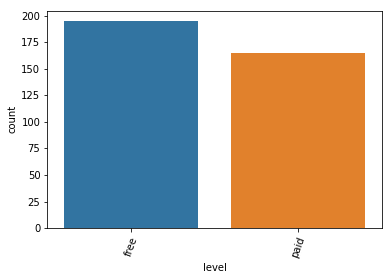

In [32]:
levels = spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS count
        FROM Sparkify
        GROUP BY level
        ORDER BY count DESC
''')
sns.barplot(x='level',y='count',data=levels.toPandas());
plt.xticks(rotation=70)

In [12]:
#define time stamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [13]:
#test with user 125
df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId =='125').sort("time").show(100)

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|               time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|2018-10-12 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|2018-10-12 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|2018-10-12 04:

In [14]:
#define churn 
churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn("page"))

In [15]:
#test
df.select(["userId", "page", "time", "level", "song","itemInSession", "sessionId","churn"]).where(df.userId =='125').sort("time").show(100)

+------+--------------------+-------------------+-----+--------------------+-------------+---------+-----+
|userId|                page|               time|level|                song|itemInSession|sessionId|churn|
+------+--------------------+-------------------+-----+--------------------+-------------+---------+-----+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|            0|      174|    0|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|            1|      174|    0|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|            2|      174|    0|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|            3|      174|    0|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|            4|      174|    0|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|            5|      174|    0|
|   125|            NextSong|2018-10-

In [16]:
#creating new view with churn added
df.createOrReplaceTempView('clean')

In [17]:
#count of users with churn flag
spark.sql(""" select churn,count(DISTINCT userId) from clean group by churn""").show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
|    0|                   225|
+-----+----------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [18]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: integer (nullable = true)



### features we will be using 

- gender
- number of sessions
- duration 
- number of songs
- errors
- level
- number of friends
- thumbs up/down count

In [21]:
#getting gender 
def gender(uid):
    result = spark.sql(""" select gender from clean where userId = '{}' """.format(uid)).first().gender
    return 0 if result=='M' else 1
#getting count of sessions
def sessionCount(uid):
    return spark.sql(""" select sessionId from clean where userId = '{}' """.format(uid)).count()
#getting count of sessions
def duration(uid):
    return spark.sql(""" select (max(ts) - min(registration))/86400000 as time from clean where userId = '{}' """.format(uid)).first().time
#getting error count
def errorsCount(uid):
    return spark.sql(""" select userId from clean where page = 'Error' and userId= '{}'""".format(uid)).count()
#getting songs count
def songsCount(uid):
    return spark.sql(""" select distinct song from clean where userId= '{}'""".format(uid)).count()
#getting level 
def level(uid):
    result = spark.sql(""" select level from clean where userId = '{}' """.format(uid)).first().level
    return 0 if result=='free' else 1
#thumbs up/down count
def thumbsUp(uid):
    return spark.sql(""" select userId from clean where page = 'Thumbs Up' and userId= '{}'""".format(uid)).count()
def thumbsDown(uid):
    return spark.sql(""" select userId from clean where page = 'Thumbs Down' and userId= '{}'""".format(uid)).count()
#friends count
def friendsCounts(uid):
    return spark.sql(""" select userId  from clean where page = 'Add Friend' and userId= '{}'""".format(uid)).count()
#label 
def label(uid):
    return spark.sql(""" select max(churn) as label from clean where userId = '{}' """.format(uid)).first().label

In [23]:
uid = '100010'
tmp = pd.DataFrame({"uid":int(uid), 
                  "label":int(label(uid)),
                  "gender":int(gender(uid)),
                  "sessions":int(sessionCount(uid)),
                  "duration":float(duration(uid)),
                  "errors":int(errorsCount(uid)),
                  "songs":int(songsCount(uid)),
                  "level":int(level(uid)),
                  "thumbsUp":int(thumbsUp(uid)),
                  "thumbsDown":int(thumbsDown(uid)),
                  "freinds":int(friendsCounts(uid)),
                 },index=[0]) 

In [24]:
tmp

,uid,label,gender,sessions,duration,errors,songs,level,thumbsUp,thumbsDown,freinds
0,100010,0,1,381,55.643657,0,270,0,17,5,4


In [27]:
#get user ids list
uids = spark.sql(""" select distinct userId from clean""")

In [28]:
ready_df = pd.DataFrame(columns=["uid","label","gender","sessions",
                  "duration","errors","songs","level","thumbsUp","thumbsDown","friends"])
#loop and create df for model
for row in uids.collect():
    uid = row.userId
    tmp = pd.DataFrame({"uid":int(uid), 
                  "label":int(label(uid)),
                  "gender":int(gender(uid)),
                  "sessions":int(sessionCount(uid)),
                  "duration":float(duration(uid)),
                  "errors":int(errorsCount(uid)),
                  "songs":int(songsCount(uid)),
                  "level":int(level(uid)),
                  "thumbsUp":int(thumbsUp(uid)),
                  "thumbsDown":int(thumbsDown(uid)),
                  "friends":int(friendsCounts(uid))
                 },index=[0]) 
    ready_df = ready_df.append(tmp)

In [29]:
ready_df.head()

,uid,label,gender,sessions,duration,errors,songs,level,thumbsUp,thumbsDown,friends
0,100010,0,1,381,55.643657,0,270,0,17,5,4
0,200002,0,0,474,70.074630,0,379,0,21,6,4
0,125,1,0,11,71.316887,0,9,0,0,0,0
0,51,1,0,2464,19.455845,1,1855,1,100,21,28
0,124,0,1,4825,131.555914,6,3340,1,171,41,74


In [30]:
ready_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 0
Data columns (total 11 columns):
uid           225 non-null object
label         225 non-null object
gender        225 non-null object
sessions      225 non-null object
duration      225 non-null float64
errors        225 non-null object
songs         225 non-null object
level         225 non-null object
thumbsUp      225 non-null object
thumbsDown    225 non-null object
friends       225 non-null object
dtypes: float64(1), object(10)
memory usage: 21.1+ KB


In [31]:
sparkDf = spark.createDataFrame(ready_df)

In [32]:
sparkDf.show()

+------+-----+------+--------+------------------+------+-----+-----+--------+----------+-------+
|   uid|label|gender|sessions|          duration|errors|songs|level|thumbsUp|thumbsDown|friends|
+------+-----+------+--------+------------------+------+-----+-----+--------+----------+-------+
|100010|    0|     1|     381| 55.64365740740741|     0|  270|    0|      17|         5|      4|
|200002|    0|     0|     474| 70.07462962962963|     0|  379|    0|      21|         6|      4|
|   125|    1|     0|      11| 71.31688657407408|     0|    9|    0|       0|         0|      0|
|    51|    1|     0|    2464|19.455844907407407|     1| 1855|    1|     100|        21|     28|
|   124|    0|     1|    4825|131.55591435185184|     6| 3340|    1|     171|        41|     74|
|     7|    0|     0|     201| 72.77818287037037|     1|  149|    0|       7|         1|      1|
|    54|    1|     1|    3437|110.75168981481481|     1| 2415|    1|     163|        29|     33|
|    15|    0|     0|    2278|

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [36]:
# Split the data into train and test
train, test = sparkDf.randomSplit([0.8, 0.2], seed=8)

In [37]:
#put in vector
assembler = VectorAssembler(inputCols=["uid","gender","errors","songs","sessions", "thumbsUp","thumbsDown","duration","level"],
                            outputCol="inputFeatures")
# Normalize 
scaler = Normalizer(inputCol="inputFeatures", outputCol="features")

In [38]:
# model
rf= RandomForestClassifier()
pipeline=Pipeline(stages=[assembler, scaler, rf])
paramgrid =ParamGridBuilder().build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")

crossval= CrossValidator(estimator=pipeline,  
                         estimatorParamMaps=paramgrid,
                         evaluator=evaluator, 
                         numFolds=10
                        )

cv_model=crossval.fit(train) 
print('f1 score:')
evaluator.evaluate(cv_model.transform(test))

f1 score:


0.5874082369043176

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.